# **Analisis de los planes prepago de Megaline**

# Descripción del proyecto.

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, `Surf` y `Ultimate`. El departamento comercial quiere saber cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan y la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

**Importante**

Megaline redondea los `segundos` a `minutos` y los `megabytes` a `gigabytes`. Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

**Sobre las tarifas**

> Surf
1.  Pago mensual: `20$`
2.  500 minutos al mes, 50 SMS y 15 GB de datos
3.  Si se exceden los límites del paquete:
  *   1 minuto: 3 centavos
  *   1 SMS: 3 centavos
  *   1 GB de datos: `10$`


> Ultimate
1.  Pago mensual: `70$`
2.  3000 minutos al mes, 1000 SMS y 30 GB de datos
3.  Si se exceden los límites del paquete:
  *   1 minuto: 1 centavo
  *   1 SMS: 1 centavo
  *   1 GB de datos: `7$`



# Inicialización 

Cargamos las librerias a utilizar

In [1]:
#Cargamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

### Cargar datos

In [2]:
# Carga los archivos de datos
try:
    calls    = pd.read_csv('/datasets/megaline_calls.csv')
    internet = pd.read_csv('/datasets/megaline_internet.csv')
    messages = pd.read_csv('/datasets/megaline_messages.csv')
    plans    = pd.read_csv('/datasets/megaline_plans.csv')
    users    = pd.read_csv('/datasets/megaline_users.csv')
except:
    calls    = pd.read_csv('/content/megaline_calls.csv')
    internet = pd.read_csv('/content/megaline_internet.csv')
    messages = pd.read_csv('/content/megaline_messages.csv')
    plans    = pd.read_csv('/content/megaline_plans.csv')
    users    = pd.read_csv('/content/megaline_users.csv')

### Explorar datos iniciales

La tabla `calls` (datos sobre las llamadas) contiene las columnas:
*  `id` — identificador único de la llamada
*  `call_date` — fecha de la llamada
*  `duration` — duración de la llamada (en minutos)
*  `user_id` — el identificador del usuario que realiza la llamada




La tabla `internet` (datos sobre las sesiones web) contiene las columnas:
*  `id` — identificador único de la sesión
*  `mb_used` — el volumen de datos gastados durante la sesión (en megabytes)
*  `session_date` — fecha de la sesión web
*  `user_id` — identificador del usuario

La tabla `messages` (datos sobre los SMS) contiene las columnas:
*  `id` — identificador único del SMS
*  `message_date` — fecha del SMS
*  `user_id` — el identificador del usuario que manda el SMS

La tabla plans (datos sobre las tarifas) contiene las columnas:
*  `plan_name` — nombre de la tarifa
*  `usd_monthly_fee` — pago mensual en dólares estadounidenses
*  `minutes_included` — minutos incluidos al mes
*  `messages_included` — SMS incluidos al mes
*  `mb_per_month_included` — datos incluidos al mes (en megabytes)
*  `usd_per_minute` — precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos el operador cobrará el minuto 101)
*  `usd_per_message` — precio por SMS tras exceder los límites del paquete
*  `usd_per_gb` — precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes)

La tabla `users` (datos sobre los usuarios) contiene las columnas:
*  `user_id` — identificador único del usuario
*  `first_name` — nombre del usuario
*  `last_name` — apellido del usuario
*  `age` — edad del usuario (en años)
*  `reg_date` — fecha de suscripción (dd, mm, aa)
*  `churn_date` — la fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)
*  `city` — ciudad de residencia del usuario
*  `plan` — nombre de la tarifa




Imprimimos la información general/resumida de cada DataFrame

In [3]:
# previsualizar los datos cargados
calls.info()

# devolver las n filas superiores del dataframe
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


In [4]:
# previsualizar los datos cargados
internet.info()

# devolver las n filas superiores del dataframe
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


In [5]:
# previsualizar los datos cargados
messages.info()

# devolver las n filas superiores del dataframe
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


In [6]:
# previsualizar los datos cargados
plans.info()

# devolver las n filas superiores del dataframe
plans.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
# previsualizar los datos cargados
users.info()

# devolver las n filas superiores del dataframe
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


In [8]:
#Visualizar estadisticas descriptivas

display(calls.describe()) 

display(internet.describe()) 

display(messages.describe()) 

display(users.describe()) 

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


### Conclusiones

*   Realizamos un checkeo inicial de nuestros datasets.
*   Con el checkeo realizado pudimos notar que no hay muchos problemas con la información, exceptuando por que los tipos de datos para `id`, `call_date`, `duration`, `session_date`, `message_date`,`first_name`,`last_name`,`city`,`reg_date`,`plan` y `churn_date`.
*  Solo faltan valores para la columna `chur_date`. Sin embargo, esta es la fecha en que el usuario dejó de usar el servicio, anteriormente nos explicaron que si no hay datos en esta columna es porque el plan aún se está utilizando.
* Podemos visualizar que los planes `Surf` y `Ultimate` incluyen 15 GB y 30 GB correspondientemente, pero en la tabla tienen el consumo incluido en MB (columna `mb_per_month_included`), sería más util tenerlo en GB, ya que además se cobra por GB consumido.

Procederemos a corregir los tipos de dato.



# Preparar los datos

En este paso procederemos a corregir el tipo de datos que detectamos anteriormente fueron establecidos erroneamente además de redondear los datos según los requerimientos.

In [9]:
#cambiando los tipos de datos para "calls"

#convertir datos a integers
calls['id'] = calls['id'].astype('int')
#redondeando los valores de "duration"
calls['duration'] = np.ceil(calls['duration']).astype(int)
#convertir datos a date time
calls['call_date'] = pd.to_datetime(calls['call_date'])

calls.dtypes

id                    int64
user_id               int64
call_date    datetime64[ns]
duration              int64
dtype: object

Megaline tiene como requerimiento que cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto.  Ante esto, validamos que los datos de `duration` esten en valores enteros (minutos).

In [10]:
calls['duration'].value_counts()

0     26834
6      7848
5      7778
7      7769
8      7718
4      7434
9      7357
3      6942
10     6918
2      6446
11     6407
1      5795
12     5750
13     5070
14     4402
15     3889
16     3011
17     2461
18     1992
19     1604
20     1243
21      910
22      671
23      461
24      324
25      235
26      157
27      118
28       62
29       58
30       27
31       18
32       13
33        6
36        3
34        2
37        1
38        1
Name: duration, dtype: int64

Todos los datos son números enteros, además tambien detectamos que hay una gran cantidad de llamadas en 0 minutos. Estas probablemente son llamadas perdidas, vamos a mantenerlos ya que de todas maneras son llamadas.

In [11]:
#cambiando los tipos de datos para "messages"

#convertir datos a integers
messages['id'] = messages['id'].astype('int')
#convertir datos a date time
messages['message_date'] = pd.to_datetime(messages['message_date'])

messages.dtypes

id                       int64
user_id                  int64
message_date    datetime64[ns]
dtype: object

Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba.

In [12]:
# cambiando los tipos de datos para "internet"

#convertir datos a integers
internet['id'] = internet['id'].astype('int')
#convertir datos a date time
internet['session_date'] = pd.to_datetime(internet['session_date'])

internet.dtypes

id                       int64
user_id                  int64
session_date    datetime64[ns]
mb_used                float64
dtype: object

En el caso de los planes, transformamos nuestra columna `mb_per_month_included` para que sus datos sean presentados en GB.

In [13]:
#Transformando MB a GB
plans['mb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans['mb_per_month_included'] = np.ceil(plans['mb_per_month_included']).astype(int)
#Renombrando la columna 'mb_per_month_included' a 'gb_per_month_included' 
plans = plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'})

plans.dtypes

messages_included          int64
gb_per_month_included      int64
minutes_included           int64
usd_monthly_pay            int64
usd_per_gb                 int64
usd_per_message          float64
usd_per_minute           float64
plan_name                 object
dtype: object

In [14]:
# cambiando los tipos de datos para "users"

#convertir datos a date time
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
#homogenizando nuestros datos de tipo string
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()

users.dtypes

user_id                int64
first_name            object
last_name             object
age                    int64
city                  object
reg_date      datetime64[ns]
plan                  object
churn_date    datetime64[ns]
dtype: object

In [15]:
#Validamos duplicados
calls.duplicated().sum()
messages.duplicated().sum()
internet.duplicated().sum()
users.duplicated().sum()

0

No tenemos datos duplicados.

In [16]:
#Validamos datos ausentes
calls.isnull().sum()
internet.isnull().sum()
plans.isnull().sum()
messages.isnull().sum()
users.isnull().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [17]:
#Verificar fechas de "churn_date"
users['churn_date'].unique()

array([                          'NaT', '2018-12-18T00:00:00.000000000',
       '2018-11-16T00:00:00.000000000', '2018-09-07T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-10-07T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2018-11-24T00:00:00.000000000',
       '2018-11-11T00:00:00.000000000', '2018-12-12T00:00:00.000000000',
       '2018-11-14T00:00:00.000000000', '2018-12-27T00:00:00.000000000',
       '2018-11-29T00:00:00.000000000', '2018-12-22T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-10-13T00:00:00.000000000',
       '2018-07-31T00:00:00.000000000', '2018-12-15T00:00:00.000000000',
       '2018-12-19T00:00:00.000000000', '2018-10-03T00:00:00.000000000',
       '2018-10-22T00:00:00.000000000', '2018-08-16T00:00:00.000000000',
       '2018-12-26T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-11-21T00:00:00.000000000', '2018-08-19T00:00:00.000000000',
       '2018-12-10T00:00:00.000000000', '2018-09-17

Solo tenemos los 466 valores ausentes de `churn_date`, que sabemos que indican que aún mantienen su plan activo. De todas maneras no es lo más optimo mantener estos datos como nulos, por lo que reemplazaremos estos datos por una fecha lejana a los datos como 2222-02-02 (los fechas de nuestro conjunto de datos son del año 2018 como acabamos de verificar).

In [18]:
# Rellenando los valores ausentes en "churn_date" con 09-09-9999
users['churn_date']=pd.to_datetime(users['churn_date'].fillna(pd.datetime.now().date().replace(month=2, day=2, year=2222)))
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


/tmp/ipykernel_73/982810282.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  users['churn_date']=pd.to_datetime(users['churn_date'].fillna(pd.datetime.now().date().replace(month=2, day=2, year=2222)))


## Conclusion

*  Notamos una gran cantidad de llamadas de 0 minutos, decidimos mantenerlas ya que de todas maneras son llamadas realizadas.
*  Cambiamos los tipos de dato que estaban mal establecidos por los correctos, homogenizamos los string poniendolos en minúsculas y nos aseguramos de que los requerimientos de Megaline se cumplan (datos en GB, tiempo de llamadas en minutos). Hemos cambiado el nombre de la columna `mb_per_month_included` por `gb_per_month_included` en el conjunto de datos `plan` para mantener la coherencia. 
*  Verificamos los valores ausentes de nuestros datos y solo encontramos los 466 datos ausentes de `churn_date`, esto porque el plan de ese cliente sigue activo. no es conveniente dejar esos datos como nulos, por lo que decidimos reemplazar los datos ausentes por una fecha alejada de nuestro conjunto original.
*  Verificamos que no hay datos duplicados.


# Enriquecer datos

Para facilitar nuestro analisis posterior vamos a buscar los siguientes parametros por usuario:

*  El número de llamadas realizadas y minutos utilizados al mes
*  La cantidad de los SMS enviados por mes.
*  El volumen de datos por mes.
*  Los ingresos mensuales de cada usuario

In [19]:
# Encontrando el número de llamadas realizadas y minutos utilizados al mes por cada usuario

#extraemos el mes de la fecha para poder agregar las llamadas realizadas en un mes
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 

#realizamos una tabla dinamica con la información que buscamos
total_calls = calls.pivot_table(index=['month', 'user_id'], values='duration', aggfunc=['count', 'sum'])
total_calls.reset_index(inplace=True)
total_calls.columns = ['month', 'user_id', 'total_calls', 'total_duration']

total_calls.head(10)

,month,user_id,total_calls,total_duration
0,1,1042,18,114
1,1,1077,42,290
2,1,1185,23,181
3,1,1196,42,287
4,1,1214,5,16
5,1,1362,42,292
6,2,1042,37,254
7,2,1077,111,776
8,2,1099,7,39
9,2,1138,42,307


In [20]:
#encontrando la cantidad de SMS enviados por mes.

#extraemos el mes de la fecha para poder agregar los SMS realizados en un mes
messages['month'] = pd. DatetimeIndex(messages['message_date']).month

#realizamos una tabla dinamica con la información que buscamos
total_messages = messages. pivot_table(index=['month','user_id'], values='id', aggfunc='count')
total_messages.reset_index(inplace=True)
total_messages.columns = ['month', 'user_id', 'total_msgs']

total_messages

,month,user_id,total_msgs
0,1,1077,37
1,1,1196,23
2,1,1214,2
3,1,1362,21
4,2,1028,12
...,...,...,...
1801,12,1491,43
1802,12,1492,37
1803,12,1494,33
1804,12,1496,11


In [21]:
#Encontrando el volumen de datos por mes.

#extraemos el mes de la fecha para poder agregar los datos utilizados en un mes
internet['month'] = pd. DatetimeIndex(internet['session_date']). month

#realizamos una tabla dinámica con la información que buscamos
total_internet = internet.pivot_table(index=['month','user_id'], values='mb_used', aggfunc='sum')
total_internet.reset_index(inplace=True)
total_internet.columns = ['month', 'user_id', 'total_mb_used']

total_internet

,month,user_id,total_mb_used
0,1,1042,1854.93
1,1,1077,10635.64
2,1,1185,6812.77
3,1,1196,8908.61
4,1,1214,1315.35
...,...,...,...
2272,12,1495,24097.40
2273,12,1496,16438.99
2274,12,1497,11106.55
2275,12,1498,23137.69


In [22]:
# Para calcular los ingresos mensuales por usuario, combinaremos el uso de datos, llamadas y SMS juntos

#Llamadas mensuales por usuario
calls_made = calls.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'calls'})

#Minutos mensuales por usuario
min_spent = calls.groupby(['user_id','month']).agg({'duration':'sum'}).rename(columns={'duration':'duration'})

#Datos mensuales por usuario
gb_used = internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).rename(columns={'mb_used':'gb_used'})
#pasamos de MB a GB
gb_used['gb_used'] = np.ceil(gb_used['gb_used']/1024)

#SMS mensuales por usuario
messages_sent = messages.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'messages'})

#Plan para cada usuario
user_plan = users[['user_id','plan','city']]
callplan_data = pd.concat([calls_made, min_spent, gb_used, messages_sent],axis=1)
callplan_data  = user_plan.merge(callplan_data.reset_index(),on='user_id', how='outer')

callplan_data

,user_id,plan,city,month,calls,duration,gb_used,messages
0,1000,ultimate,"atlanta-sandy springs-roswell, ga msa",12.0,16.0,124.0,2.0,11.0
1,1001,surf,"seattle-tacoma-bellevue, wa msa",8.0,27.0,182.0,7.0,30.0
2,1001,surf,"seattle-tacoma-bellevue, wa msa",9.0,49.0,315.0,14.0,44.0
3,1001,surf,"seattle-tacoma-bellevue, wa msa",10.0,65.0,393.0,22.0,53.0
4,1001,surf,"seattle-tacoma-bellevue, wa msa",11.0,64.0,426.0,19.0,36.0
...,...,...,...,...,...,...,...,...
2298,1498,surf,"new york-newark-jersey city, ny-nj-pa msa",12.0,39.0,339.0,23.0,NaN
2299,1499,surf,"orlando-kissimmee-sanford, fl msa",9.0,41.0,346.0,13.0,NaN
2300,1499,surf,"orlando-kissimmee-sanford, fl msa",10.0,53.0,385.0,20.0,NaN
2301,1499,surf,"orlando-kissimmee-sanford, fl msa",11.0,45.0,308.0,17.0,NaN


In [23]:
#Nos aseguramos de que aún se mantienen nuestros 500 usuarios
callplan_data["user_id"].nunique()

500

In [24]:
#Verificamos valores ausentes
callplan_data.isnull().sum()

user_id       0
plan          0
city          0
month        10
calls        45
duration     45
gb_used      26
messages    497
dtype: int64

Podemos ver que tenemos usuarios que aún no han realizado llamadas, usado SMS o datos, de todas maneras son usuarios validos.

In [25]:
#Reemplazamos los valores ausentes por 0
callplan_data  =  callplan_data.fillna(0)
callplan_data

,user_id,plan,city,month,calls,duration,gb_used,messages
0,1000,ultimate,"atlanta-sandy springs-roswell, ga msa",12.0,16.0,124.0,2.0,11.0
1,1001,surf,"seattle-tacoma-bellevue, wa msa",8.0,27.0,182.0,7.0,30.0
2,1001,surf,"seattle-tacoma-bellevue, wa msa",9.0,49.0,315.0,14.0,44.0
3,1001,surf,"seattle-tacoma-bellevue, wa msa",10.0,65.0,393.0,22.0,53.0
4,1001,surf,"seattle-tacoma-bellevue, wa msa",11.0,64.0,426.0,19.0,36.0
...,...,...,...,...,...,...,...,...
2298,1498,surf,"new york-newark-jersey city, ny-nj-pa msa",12.0,39.0,339.0,23.0,0.0
2299,1499,surf,"orlando-kissimmee-sanford, fl msa",9.0,41.0,346.0,13.0,0.0
2300,1499,surf,"orlando-kissimmee-sanford, fl msa",10.0,53.0,385.0,20.0,0.0
2301,1499,surf,"orlando-kissimmee-sanford, fl msa",11.0,45.0,308.0,17.0,0.0


In [26]:
# Calculando los ingresos mensuales de cada usuario

#Creamos una funcion
def calculate_revenue(row):
    user_id = row['user_id']
    gb_used = row['gb_used']
    messages_sent = row['messages']
    minutes_sent = row['duration']

    #Extraemos el plan y los detalles para guardarlos en variables
    plan_type = users.loc[users['user_id'] == user_id, 'plan'].iloc[0]
    plan_detail = plans.loc[plans['plan_name'] == plan_type]
    
    #Extraemos los detalles de cada plan y los guardamos en variables
    minutes_included = plan_detail['minutes_included'].iloc[0]
    messages_included = plan_detail['messages_included'].iloc[0]
    gb_per_month_included = plan_detail['gb_per_month_included'].iloc[0]

    #Extraemos el valor mensual de cada plan
    usd_monthly_pay = plan_detail['usd_monthly_pay'].iloc[0]

    #Extraemos los valores luego de exceder los limites
    usd_per_gb = plan_detail['usd_per_gb'].iloc[0]
    usd_per_message =plan_detail['usd_per_message'].iloc[0]
    usd_per_minute = plan_detail['usd_per_minute'].iloc[0]

    #Creamos nuestras variables para guardar los totales luego de exceder los limites del plan
    total_internet_cost = 0
    total_message_cost = 0    
    total_minute_cost = 0  
    #Realizamos los calculos segun corresponda
    if minutes_sent > minutes_included:
        total_minute_cost = (minutes_sent - minutes_included) * usd_per_minute 
    if messages_sent > messages_included:
        total_message_cost = (messages_sent - messages_included) *  usd_per_message
    if gb_used > gb_per_month_included:
        total_internet_cost = (gb_used - gb_per_month_included) *  usd_per_gb 
    
    return (total_minute_cost+total_message_cost+total_internet_cost+usd_monthly_pay)

#Aplicamos nuestra función a nuestra tabla combinada
callplan_data['revenue'] = callplan_data.apply(calculate_revenue, axis=1)

callplan_data

,user_id,plan,city,month,calls,duration,gb_used,messages,revenue
0,1000,ultimate,"atlanta-sandy springs-roswell, ga msa",12.0,16.0,124.0,2.0,11.0,70.00
1,1001,surf,"seattle-tacoma-bellevue, wa msa",8.0,27.0,182.0,7.0,30.0,20.00
2,1001,surf,"seattle-tacoma-bellevue, wa msa",9.0,49.0,315.0,14.0,44.0,20.00
3,1001,surf,"seattle-tacoma-bellevue, wa msa",10.0,65.0,393.0,22.0,53.0,90.09
4,1001,surf,"seattle-tacoma-bellevue, wa msa",11.0,64.0,426.0,19.0,36.0,60.00
...,...,...,...,...,...,...,...,...,...
2298,1498,surf,"new york-newark-jersey city, ny-nj-pa msa",12.0,39.0,339.0,23.0,0.0,100.00
2299,1499,surf,"orlando-kissimmee-sanford, fl msa",9.0,41.0,346.0,13.0,0.0,20.00
2300,1499,surf,"orlando-kissimmee-sanford, fl msa",10.0,53.0,385.0,20.0,0.0,70.00
2301,1499,surf,"orlando-kissimmee-sanford, fl msa",11.0,45.0,308.0,17.0,0.0,40.00


In [27]:
#Nos aseguramos de que aún se mantienen nuestros 500 usuarios
callplan_data["user_id"].nunique()

500

## Conclusión
Calculamos los ingresos mensuales de cada usuario fusionando los conjuntos de datos de llamadas, SMS, datos y usuarios. Ahora nuestros datos se combinan con todas las columnas de uso de los usuarios e ingresos.

# Analizar los datos

Procederemos a analizar el comportamiento de los clientes, para ello calcularemos la media, la varianza y la desviación estándar para los clientes de cada plan.


In [28]:
# Calculamos la media, varianza y desviación estándar para el plan Surf

#Separamos nuestros datos del plan surf
surf_data = callplan_data.query('plan =="surf"')
#Aplicamos una funcion para calcular los ingresos
for column in surf_data[['calls','duration','messages','gb_used','revenue']]:
    
    print('Media de {}: {:.2f}'.format(column,surf_data[column].mean()))
    
    print('Mediana de {}: {:.2f}'.format(column,surf_data[column].median()))
    
    print('Varianza de {}: {:.2f}'.format(column,np.var(surf_data[column])))
    
    print('Desviación estandar de {}: {:.2f} \n'.format(column,np.std(surf_data[column])))

Media de calls: 59.58
Mediana de calls: 60.00
Varianza de calls: 1034.15
Desviación estandar de calls: 32.16 

Media de duration: 427.12
Mediana de duration: 424.00
Varianza de duration: 55420.46
Desviación estandar de duration: 235.42 

Media de messages: 31.04
Mediana de messages: 24.00
Varianza de messages: 1125.40
Desviación estandar de messages: 33.55 

Media de gb_used: 16.61
Mediana de gb_used: 17.00
Varianza de gb_used: 62.36
Desviación estandar de gb_used: 7.90 

Media de revenue: 60.55
Mediana de revenue: 40.18
Varianza de revenue: 3060.51
Desviación estandar de revenue: 55.32 



In [29]:
# Calculamos la media, varianza y desviación estándar para el plan Ultimate

#Separamos nuestros datos del plan ultimate
ultimate_data = callplan_data.query('plan =="ultimate"')
#Aplicamos una funcion para calcular los ingresos
for column in ultimate_data[['calls','duration','messages','gb_used','revenue']]:
    
    print('Media de {}: {:.2f}'. format(column,ultimate_data[column].mean()))
    
    print('Mediana de {}: {:.2f}'. format(column,ultimate_data[column].median()))
    
    print('Varianza de {}: {:.2f}'. format(column,np.var(ultimate_data[column])))
    
    print('Desviación estándar de {}: {:.2f} \n'.format(column,np.std(ultimate_data[column])))

Media de calls: 60.29
Mediana de calls: 61.00
Varianza de calls: 1117.66
Desviación estándar de calls: 33.43 

Media de duration: 428.07
Mediana de duration: 421.50
Varianza de duration: 58463.02
Desviación estándar de duration: 241.79 

Media de messages: 37.34
Mediana de messages: 30.00
Varianza de messages: 1208.16
Desviación estándar de messages: 34.76 

Media de gb_used: 17.21
Mediana de gb_used: 17.00
Varianza de gb_used: 60.07
Desviación estándar de gb_used: 7.75 

Media de revenue: 72.30
Mediana de revenue: 70.00
Varianza de revenue: 128.98
Desviación estándar de revenue: 11.36 



*   En promedio los usuarios del plan `Surf` realiza `60` llamadas de `428` minutos, envía `32` mensajes y usa `17 GB` en datos al mes.
*   Mientras que los usuarios del plan `Ultimate` realiza `61` llamadas de `429` minutos, envía `38` mensajes y usa `18 GB` en datos al mes.
*   Podemos ver que los usuarios del plan `Ultimate` tiende a tener un consumo levemente mayor que los del plan `Surf`, que es imaginable por las caracteristicas de cada plan.
*   En promedio los usuarios del plan `Surf` suele exceder los límites de datos de su plan base, por lo que deben pagar extra por cada GB excedido.
*   En el caso del plan `Ultimate`, el usuario promedio no suele excederse en ningún limite de los establecidos en su plan, porque no suelen pagar extras.
*   El uso típico que se le da a cada plan es muy similar pero en el caso del plan `Ultimate` es levemente mayor, a pesar de ello, los que suelen excederse de sus limites son los usuarios del plan `Surf`. 
* A pesar de que los usuarios de `Surf` suelen pagar por excedentes, el plan con más ingresos sigue siendo `Ultimate` por el valor base mensual.


Continuemos investigando y trazemos histogramas para comprobar nuestras hipotesis.

In [30]:
def distribution(parameter):
    print('Histograma y boxplot de {}'.format(parameter))
    print('')
    fig, axes = plt.subplots(1,2,figsize=(16, 5))
    sns.histplot(data=callplan_data,bins=80,x=parameter,hue='plan',ax=axes[0])
    sns.boxplot(data=callplan_data,x=parameter,y='plan',showfliers = True, orient="h", palette="Set2",ax=axes[1])
    if callplan_data[parameter].median()>callplan_data[parameter].median():
        print('La distribución está sesgada a la derecha')
    else:
        print('La distribución está sesgada a la izquierda.')

<div class="alert alert-block alert-info">
Toda la razón.<a class="tocSkip"></a>
</div>

Histograma y boxplot de calls

La distribución está sesgada a la izquierda.


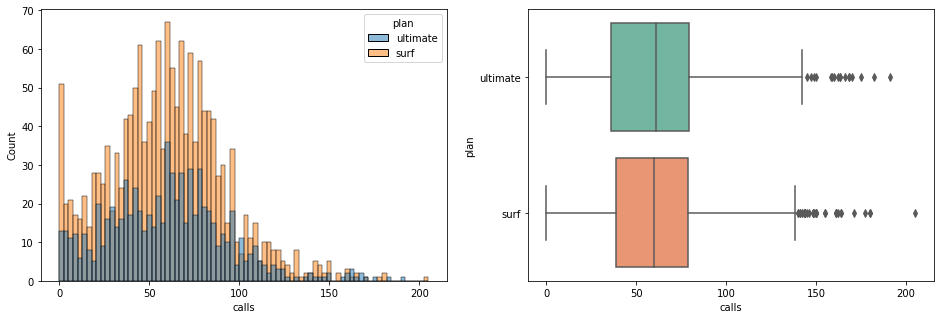

In [31]:
distribution('calls')

Histograma y boxplot de duration

La distribución está sesgada a la izquierda.


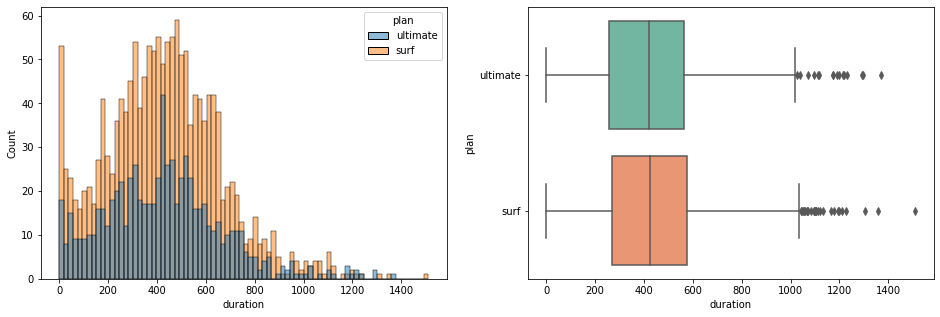

In [32]:
distribution('duration')

Histograma y boxplot de messages

La distribución está sesgada a la izquierda.


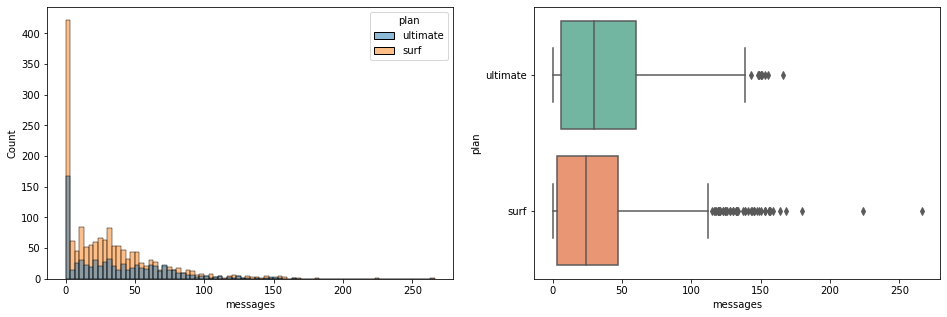

In [33]:
distribution('messages')

Histograma y boxplot de gb_used

La distribución está sesgada a la izquierda.


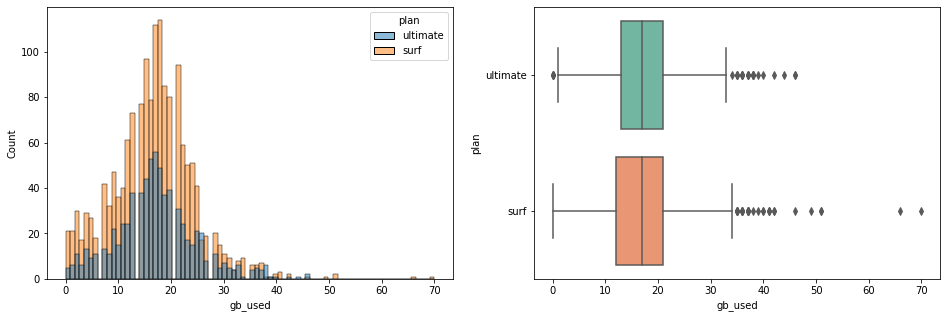

In [34]:
distribution('gb_used')

Histograma y boxplot de revenue

La distribución está sesgada a la izquierda.


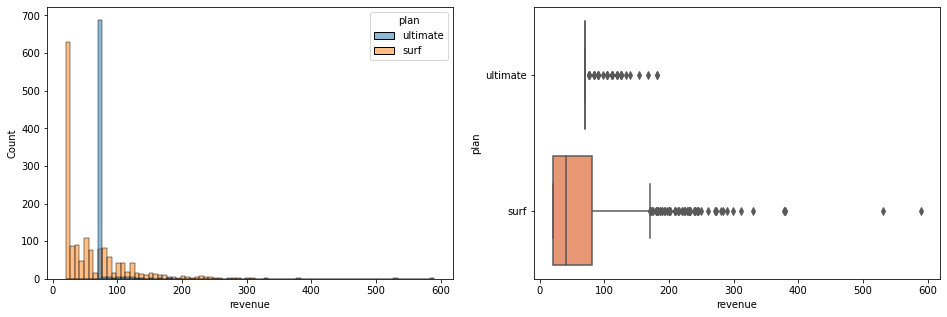

In [35]:
distribution('revenue')

**Conclusión**

*  A pesar de que los promedios nos indicaran que los usuarios en promedio del plan `Surf` tenía un consumo promedio menor que los del plan `Ultimate`, podemos ver en los histogramas que los clientes con el plan `Ultimate` usan menos frecuentemente sms, datos de navegación y minutos que los clientes de `Surf`. Estos resultados también se pueden deber a que hay menos usuarios en el plan `Ultimate`.
*  De los boxplot podemos ver que la duracion de llamadas de ambos planes en muy similar, a diferencia del uso de sms que vemos como algunos clientes del plan `Ultimate` tienen cantidades más altas.
* En el caso de los ingresos, tenemos que casi todos los usuarios de `Ultimate` pagan alrededor de `70$`, por lo que podemos inferir que el cupo del plan `Ultimate` es suficiente para la gran mayoria de usuarios, a diferencia de los usuarios de `Surf` que tienen una distribucion de frecuencias más amplia debido a exceder sus cupos.

# Probar las hipotesis

Se nos presentan dos hipotesis para nuestros datos:

1.   El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
2.   El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

En este punto probaremos ambas hipotesis:




**El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.**

Antes de comenzar a realizar nuestro procedimiento para validar si el ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere, validaremos si la varianza de los ingresos para ambos planes varían, de esta forma podremos aplicar con mayor certeza nuestro t-test. Usaremos una prueba levene con los siguientes parametros:

$$H_0: \text{El varianza del los ingresos de los usuarios de las tarifas Ultimate y Surf no difiere.}$$
$$H_1: \text{El varianza del los ingresos de los usuarios de las tarifas Ultimate y Surf difiere.}$$
$$alpha: \text{5%}$$


In [36]:
#importamos levene
from scipy.stats import levene

alpha = 0.05 # significación estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

stat, results= levene(surf_data['revenue'], ultimate_data['revenue'])

print('p-value:', results)

if (results < alpha):
        print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')

p-value: 3.070976609395645e-83
Rechazamos la hipótesis nula


Se rechaza la hipótesis nula sobre la igualdad de varianzas para los ingresos de usuarios del plan `Surf` y `Ultimate`, por lo que hay una diferencia considerable entre la dispersion de los datos para ambos planes ambos planes. Con esto podemos proceder a realizar un t-test a nuestros datos y determinar la hipotesis inicial

$$H_0: \text{El ingreso promedio de los usuarios de las tarifas Ultimate y Surf no difiere.}$$
$$H_1: \text{El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.}$$
$$alpha: \text{5%}$$
$$equal var = \text{False}$$

Empezamos con la hipótesis nula H₀ que son los ingresos medios de los usuarios de los planes `Ultimate` y `Surf` no difieren. La hipótesis alternativa, H₁ es que los ingresos medios de los usuarios de los planes `Ultimate` y `Surf` difieren. Para ello, utilizaremos un alfa de `0,05`, lo que significa que sólo en el 5% de los casos rechazaremos la hipótesis nula cuando sea cierta. Sabemos además que la varianza de ambas muestras no es igual por lo que el parametro `equal_var` será igual a `False`.

In [37]:
#Calculamos la media y desviación estándar de cada plan
surf_mean = surf_data['revenue'].mean()
surf_std = surf_data['revenue'].std()
print('Media de Surf:',surf_mean,'Desviación estándar de Surf:',surf_std)
ultimate_mean = ultimate_data['revenue'].mean()
ultimate_std = ultimate_data['revenue'].std()
print('Media de Ultimate:',ultimate_mean,'Desviación estándar de Ultimate:',ultimate_std)

Media de Surf: 60.551728942368584 Desviación estándar de Surf: 55.33937895940068
Media de Ultimate: 72.3011049723757 Desviación estándar de Ultimate: 11.364838590013967


In [38]:
alpha = 0.05 # significación estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(surf_data['revenue'], ultimate_data['revenue'],equal_var = False)

print('p-value:', results.pvalue)


if (results.pvalue < alpha):
        print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')

p-value: 1.2184115852123163e-15
Rechazamos la hipótesis nula


Tras someter nuestra muestra de datos a la prueba con un nivel de significación estadística de `0,05`, se ha rechazado nuestra hipótesis sobre la igualdad de las medias de las muestras pareadas y la media de `Surf` no es igual a la media de `Ultimate`.

**Conclusión 1**

*  El varianza del los ingresos de los usuarios de las tarifas Ultimate y Surf difiere.
*  El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
*  Con estos resultados más nuestro analisis anterior, podemos decir que hay una diferencia considerable entre los ingresos mensuales de cada plan de Megaline, en la cual hay una tendencia clara a que el los ingresos de `Ultimate` son superiores en promedio. 


**El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.**

Al igual que en el caso anterior, comenzaremos comprobando la igualdad de varianzas de nuestros ingresos dentro y fuera del área Nueva York y Nueva Jersey, para ello aplicaremos una prueba levene:

$$H_0: \text{La varianza de ingresos del área de estados Nueva York-Nueva Jersey es igual al de los usuarios de otras regiones.}$$
$$H_1: \text{La varianza de ingresos del área de estados Nueva York-Nueva Jersey no es igual al de los usuarios de otras regiones.}$$
$$alpha: \text{5%}$$

In [39]:
alpha = 0.05 # significación estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

#Separamos nuestros datos de NY-NJ y el resto en distintos dataframes
user_data_NY_NJ = callplan_data.query('city == "new york-newark-jersey city, ny-nj-pa msa"')
user_data_not_NY_NJ = callplan_data.query('city != "new york-newark-jersey city, ny-nj-pa msa"')
#Aplicamos la prueba levene
stat, results= levene(user_data_NY_NJ['revenue'], user_data_not_NY_NJ['revenue'])

print('p-value:', results)

if (results < alpha):
        print('Rechazamos la hipótesis nula')
else:
    print('No rechazamos la hipótesis nula')

p-value: 0.13166997048838908
No rechazamos la hipótesis nula


No se rechaza la hipótesis nula, por lo que la varianza de los ingresos del área de estados Nueva York-Nueva Jersey es muy similar a la de los usuarios de otras regiones. Procedemos a usar esta info en nuestro t-test:

$$H_0: \text{El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es igual al de los usuarios de otras regiones.}$$
$$H_1: \text{El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.}$$
$$alpha: \text{5%}$$
$$equal var = \text{True}$$

Veamos los pasos para probar la segunda hipótesis. Empezamos con la hipótesis nula H₀, que es "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey no es diferente al de los usuarios de otras regiones". La hipótesis alternativa, H₁, es "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones".

Para ello, utilizaremos un alfa de 0,05, lo que significa que sólo en el 5% de los casos rechazaremos la hipótesis nula cuando sea cierta.


In [40]:
#El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es 
#diferente al de los usuarios de otras regiones.

#Calculamos sus media y desviación estándar
user_data_NY_NJ_mu = user_data_NY_NJ['revenue'].mean().round(decimals=2)
user_data_not_NY_NJ_mu = user_data_not_NY_NJ['revenue'].mean().round(decimals=2)
user_data_NY_NJ_std = user_data_NY_NJ['revenue'].std().round(decimals=2)
user_data_not_NY_NJ_std = user_data_not_NY_NJ['revenue'].std().round(decimals=2)

print('Media de usuarios de NY-NJ: ', user_data_NY_NJ_mu, 'Desviación estándar de usuarios de NY-NJ: ', user_data_NY_NJ_std)

print('Media de usuarios de otras regiones: ', user_data_not_NY_NJ_mu, 
      'Desviación estándar de usuarios de otras regiones: ',user_data_not_NY_NJ_std)

Media de usuarios de NY-NJ:  59.95 Desviación estándar de usuarios de NY-NJ:  43.48
Media de usuarios de otras regiones:  65.09 Desviación estándar de usuarios de otras regiones:  47.13


In [41]:
alpha = 0.05 # significación estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(user_data_NY_NJ['revenue'], user_data_not_NY_NJ['revenue'], equal_var= True)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print('Rechazamos la hipótesis nula')
else:
        print('No rechazamos la hipótesis nula')

p-value:  0.04974528277407551
Rechazamos la hipótesis nula


El t-test nos dice que los ingresos medios de los usuarios de la zona de Nueva York y Nueva Jersey son diferentes a los de los usuarios de otras regiones, lo que significa que los usuarios de las grandes ciudades aportan más ingresos que los de otras regiones, independientemente del tipo de planes de llamadas que elijan.


# Conclusión general

*  Luego de conocer nuestros datos, cambiamos los tipos de datos que estaban mal establecidos para evitar conflictos en nuestro análisis posterior, renombramos columnas, preprocesamos los valores ausentes y nos aseguramos de que nuestra data estuviera lista para trabajarla.  
*  Enriquecimos nuestros datos para facilitar nuestro análisis añadiendo parámetros como llamadas, minutos, SMS y datos utilizados al mes por cada usuario, además de los ingresos mensuales para analizar su rentabilidad.
*  Procedimos a analizar el comportamiento de los clientes calculando la media, varianza y desviación estándar por cada plan, encontramos que los valores promedio para los usuarios del plan `Ultimate` tienden a ser ligeramente mayores, exceptuando los ingresos mensuales, ya que podemos notar un aumento mucho mayor para el plan `Ultimate`. Los ingresos para el plan `Surf` es de `60.55$` mientras que para el `Ultimate` es `72.30$` en promedio, por lo que podemos concluir que `Ultimate` es el plan que genera más ingresos por usuario. En este punto notamos también que los usuarios del plan `Surf` suelen excederse de los cupos base de su plan, por lo que pagan extras.
*  Luego nos centramos en generar graficos que nos ayudaran a aclarar nuestras primeras conclusiones y nos ayudaran a generar nuevas, para ello trazamos histogramas y boxplots. De este punto pudimos detectar que en realidad los que más consumen recursos (llamadas, sms y datos) son los del plan `Surf`, esto se debe a que la mayoria de los usuarios son de este plan.
*  El uso de llamadas de los clientes `Surf` y `Ultimate` es muy similar, a diferencia de los sms que los ususarios `Ultimate` suelen usar con mucha más regularidad.
*  Tambien confirmamos que los usuarios `Surf` tienen a excederse del cupo de sus planes, a diferencia de los `Ultimate` pagan solo el cargo mensual.
*  Luego de analisar nuestros datos procedimos a  realizar la prueba de hipotesis planteadas por el cliente:
    1. El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
    Después de ejecutar nuestra muestra de datos a través de una prueba levene p t-test con un nivel de significancia estadística de 0.05, nuestra hipótesis sobre la igualdad de las medias de muestras pareadas fue rechazada y el promedio de surf_revenue no es igual al promedio de ultimate_revenue. Parece que la media de los ingresos `Ultimate` es mucho más alta que los ingresos de `Surf`.
    2. El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.
    Después de ejecutar nuestra muestra de datos a través de un t-test con un nivel de significancia estadística de 0.05, nuestra hipótesis sobre la igualdad de las medias de muestras pareadas fue rechazada. Al parecer la media de todas las demás regiones es ligeramente superior a los ingresos de Nueva York-Nueva-Jersey. Quizás haya más clientes finales fuera del área de Nueva York-Nueva Jersey.
    
    
**Recomendaciones para Megaline:**
-  Los usuarios del plan `Surf` tienden a sobrepasar el cupo de su plan, quizas sería una buena idea crear un plan intermedio para toda la gente que necesita un valor más bajo pero necesita un poco más de cupo.
-  El plan `Ultimate` genera una cantidad significativamente mayor de ingresos que `Surf`, se recomienda ajustar el presupuesto para mejorar la publicidad o promocionar `Ultimate`.
-  Al parecer las ciudades de Nueva York-Nueva Jersey no genera tantos ingresos vs el resto de áreas como se podría creer por ser grandes ciudades, quizas sería necesario potenciar los planes en estas ciudades o simplemente centrar los esfuerzos en el resto de áreas.